In [1]:
# code set-up steps #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# data sets
imdc_disaster_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/IDMC_disaster_corrected.xlsx')
imdc_conflict_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/IDMC_Internal_Displacement_Conflict-Violence_corrected.xlsx')
ocha_refugees_df = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/OCHA_refugees_corrected.csv')
ocha_data_df = pd.read_csv('ocha_weighted_avg.csv')

In [26]:
# organizing the data

# first, grouping the data that is disconnected
imdc_disaster_grouped = imdc_disaster_df.groupby(['Country / Territory', 'Year'])['Disaster Internal Displacements (Raw)'].sum()
imdc_disaster_grouped = imdc_disaster_grouped.reset_index()

# checked with print statement, looks good! 

# merging dataframes
tot_disaster_refugees = imdc_disaster_grouped.rename(columns= {'Country / Territory': 'Country'})
imdc_conflict_df = imdc_conflict_df.rename(columns= {'Name': 'Country'})
ocha_refugees_df = ocha_refugees_df.rename(columns= {'Country of origin': 'Country'})
ocha_data_df = ocha_data_df.rename(columns= {' Crisis with appeal lasting one year or more ':'Country'})

imdc_merged_df = pd.merge(tot_disaster_refugees, imdc_conflict_df, on= 'Country', how= 'outer')
refugees_all = pd.merge(imdc_merged_df, ocha_refugees_df, on= 'Country', how= 'outer')


In [37]:
# looking just at conflict numbers vs. PiN

# fixing the data flaws
refugees_all['Year_x'] = pd.to_datetime(refugees_all['Year_x'], format= '%Y', errors= 'coerce')
refugees_all['Year_y'] = pd.to_datetime(refugees_all['Year_y'], format= '%Y', errors= 'coerce')
refugees_all['Year'] = pd.to_datetime(refugees_all['Year'], format= '%Y', errors= 'coerce')

# setting up OCHA
unesa_pop_df = pd.read_excel('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/total_pop_key.xlsx')
unesa_pop_df['Year'] = pd.to_datetime(unesa_pop_df['Time'], format= '%Y', errors= 'coerce')
ocha_data_df['Year'] = pd.to_datetime(ocha_data_df['Year'], format= '%Y', errors= 'coerce')
ocha_grouped = ocha_data_df.groupby(['Country', 'Year'])[' People in Need  '].sum()
ocha_grouped = ocha_grouped.reset_index()

'''
# commented out to prevent redundancy
ocha_grouped.to_csv("ocha_cleaned.csv", index=False)
unesa_pop_df.to_csv("unesa_cleaned.csv", index=False)
'''

In [ ]:
# data creation and plotting
merged_ocha = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/merged_ocha_unesa.csv')
merged_ocha['people_in_need'].dropna()
merged_ocha['people_in_need'] = pd.to_numeric(merged_ocha['people_in_need'], errors='coerce').astype('Int64')
merged_ocha['total_population'].dropna()
merged_ocha['total_population'] = pd.to_numeric(merged_ocha['total_population'], errors='coerce').astype('Int64')

merged_ocha['PiN'] = merged_ocha['people_in_need']/merged_ocha['total_population']

# bringing in conflict data 
imdc_conflict_grouped = imdc_conflict_df.groupby(['Country', 'Year'])[['Conflict Internal Displacements (Raw)', 'Conflict Internal Displacements (Raw)']].sum().reset_index()

merged_ocha['Country'] = merged_ocha['Country'].astype(str)
imdc_conflict_grouped['Country'] = imdc_conflict_grouped['Country'].astype(str)
merged_ocha['Year'] = pd.to_numeric(merged_ocha['Year'], errors='coerce').astype('Int64')
imdc_conflict_grouped['Year'] = pd.to_numeric(imdc_conflict_grouped['Year'], errors= 'coerce').astype('Int64')

imdc_conflict_grouped

'''
merged_ocha.to_csv("merged_ocha.csv", index=False)
imdc_conflict_grouped.to_csv("imdc_grouped.csv", index=False)

'''

                            OLS Regression Results                            
Dep. Variable:         people_in_need   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           0.000254
Time:                        13:02:06   Log-Likelihood:                -3595.3
No. Observations:                 212   AIC:                             7195.
Df Residuals:                     210   BIC:                             7201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

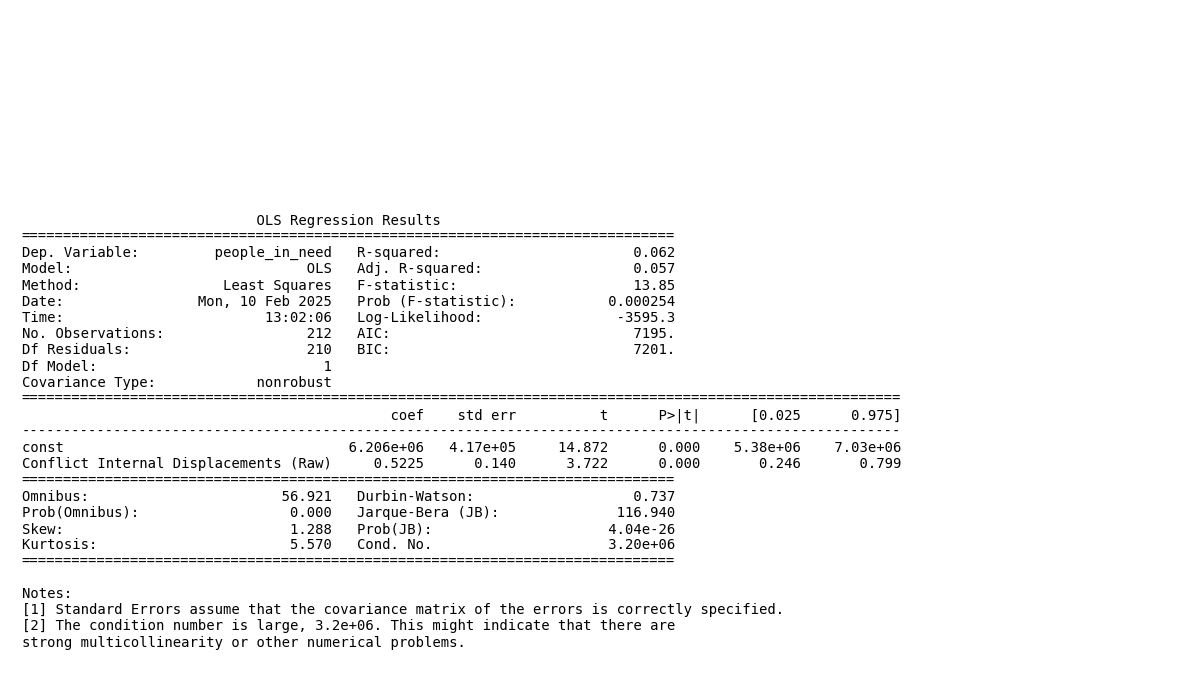

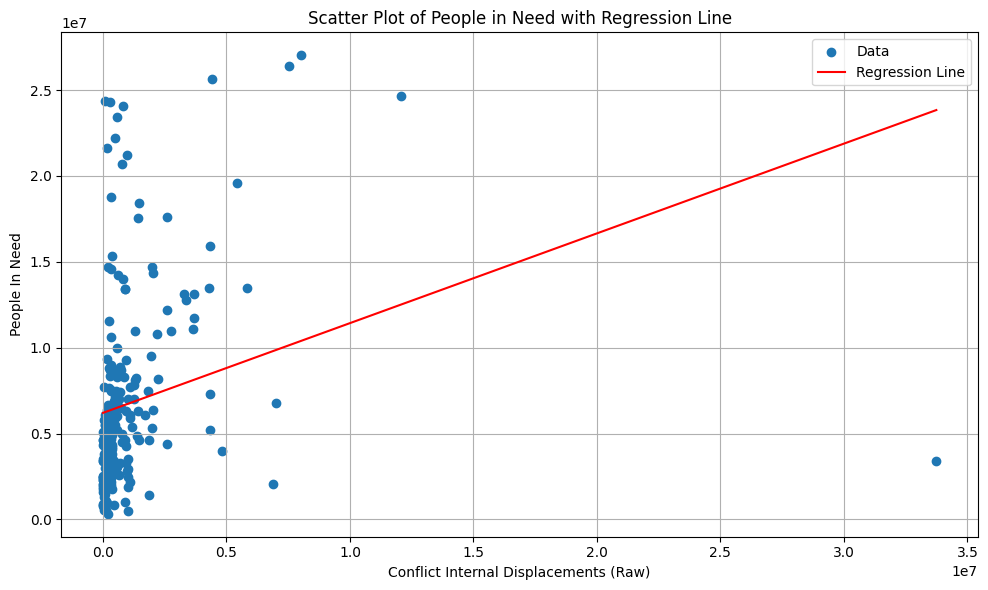

In [60]:
# re-loading the data, dropping missing rows
conflict_merged = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/final_ocha_pin.csv')
conflict_merged = conflict_merged[conflict_merged['Conflict Internal Displacements (Raw)'] != 0]

# linear regression
y = conflict_merged['people_in_need'] 
X = conflict_merged['Conflict Internal Displacements (Raw)']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace') 
plt.axis('off')
plt.tight_layout()
plt.savefig('model_summary.png')

# creating a chart!
plt.figure(figsize=(10, 6))
plt.scatter(conflict_merged['Conflict Internal Displacements (Raw)'], conflict_merged['people_in_need'], label= 'Data')
y_pred = model.predict(sm.add_constant(conflict_merged['Conflict Internal Displacements (Raw)']))
x_vals = conflict_merged['Conflict Internal Displacements (Raw)'].sort_values()
y_vals = model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red', label='Regression Line')
plt.xlabel('Conflict Internal Displacements (Raw)')
plt.ylabel('People In Need')
plt.title('Scatter Plot of People in Need with Regression Line')
plt.legend()
plt.grid(True)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.savefig('scatterplot_with_regression.png') # Save as PNG
plt.show()

In [71]:
# re-loading the data, dropping missing rows 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

conflict_merged = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/final_ocha_pin.csv')
conflict_merged = conflict_merged[conflict_merged['Conflict Internal Displacements (Raw)'] != 0]

conflict_merged['Year'] = pd.to_numeric(conflict_merged['Year'], errors='coerce')
conflict_merged['people_in_need'] = pd.to_numeric(conflict_merged['people_in_need'], errors='coerce')
conflict_merged['Conflict Internal Displacements (Raw)'] = pd.to_numeric(conflict_merged['Conflict Internal Displacements (Raw)'], errors='coerce')

# Handle NaNs (choose ONE of the following strategies)
conflict_merged = conflict_merged.dropna(subset=['Year', 'people_in_need', 'Conflict Internal Displacements (Raw)'])  # Drop rows with NaNs

target_years = [2022, 2021, 2020, 2019, 2017]
results_table = pd.DataFrame(columns=['Year', 'R-squared', 'p-value', 'Coefficient'])

for year in target_years:
    # Subset the data for the current year
    subset = conflict_merged[conflict_merged['Year'] == year]

    # Check if the subset is empty to avoid errors
    if not subset.empty:
        # Define dependent and independent variables
        y = subset['people_in_need']
        X = subset['Conflict Internal Displacements (Raw)']
        X = sm.add_constant(X)

        # Fit the linear regression model
        model = sm.OLS(y, X).fit()

        # Store the results in the table
        results_table = pd.concat([results_table, pd.DataFrame({
            'Year': [year],
            'R-squared': [model.rsquared],
            'p-value': [model.pvalues[1]],  # p-value for the independent variable
            'Coefficient': [model.params[1]]  # Coefficient for the independent variable
        })], ignore_index=True)
    else:
        print(f"No data found for year {year}. Skipping regression.")

print(results_table)

# Save the results table to a CSV file (optional)
results_table.to_csv('ocha_regression_results_by_year.csv', index=False)


   Year  R-squared   p-value  Coefficient
0  2022   0.002033  0.850280    -0.047026
1  2021   0.340649  0.008704     3.038880
2  2020   0.340788  0.006886     3.399050
3  2019   0.272719  0.018175     2.713142
4  2017   0.248526  0.029815     1.467568


/var/folders/6y/z0315m514rx79r25lwyjx_d80000gn/T/ipykernel_9764/2321045478.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'p-value': [model.pvalues[1]],  # p-value for the independent variable
/var/folders/6y/z0315m514rx79r25lwyjx_d80000gn/T/ipykernel_9764/2321045478.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'Coefficient': [model.params[1]]  # Coefficient for the independent variable
/var/folders/6y/z0315m514rx79r25lwyjx_d80000gn/T/ipykernel_9764/2321045478.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longe

In [81]:
# re-loading the data, dropping missing rows
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import matplotlib.transforms as transforms

summary_stats_table = pd.DataFrame(columns=['Year', 'Mean', 'Std', 'Min', 'Max', 'Count'])

for year in target_years:
    subset = conflict_merged[conflict_merged['Year'] == year]

    if not subset.empty:
        summary_stats = subset['Conflict Internal Displacements (Raw)'].describe()
        summary_stats_table = pd.concat([summary_stats_table, pd.DataFrame({
            'Year': [year],
            'Mean': [summary_stats['mean']],
            'Std': [summary_stats['std']],
            'Min': [summary_stats['min']],
            'Max': [summary_stats['max']],
            'Count': [summary_stats['count']]
        })], ignore_index=True)
    else:
        print(f"No data found for year {year}. Skipping summary statistics.")

print("\nSummary Statistics:\n", summary_stats_table)
summary_stats_table.to_csv('summary_statistics_by_year.csv', index=False)


Summary Statistics:
    Year          Mean           Std     Min         Max  Count
0  2022  2.536746e+06  7.550923e+06   728.0  33740646.0   20.0
1  2021  8.675686e+05  1.182005e+06    80.0   5423566.0   19.0
2  2020  7.019907e+05  1.179094e+06   148.0   4417780.0   20.0
3  2019  6.161766e+05  1.027629e+06   120.0   3694280.0   20.0
4  2017  9.983557e+05  1.623454e+06  1400.0   5822544.0   19.0


/var/folders/6y/z0315m514rx79r25lwyjx_d80000gn/T/ipykernel_9764/1577580877.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_stats_table = pd.concat([summary_stats_table, pd.DataFrame({


                            OLS Regression Results                            
Dep. Variable:         people_in_need   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     13.85
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           0.000254
Time:                        13:11:35   Log-Likelihood:                -3595.3
No. Observations:                 212   AIC:                             7195.
Df Residuals:                     210   BIC:                             7201.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

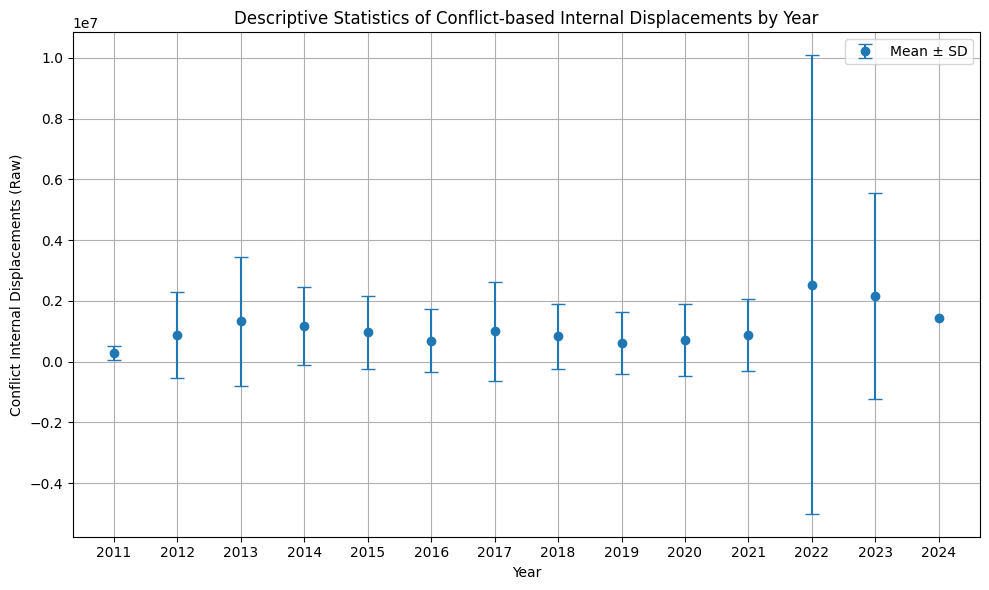


Descriptive Statistics Table:
    Year  count          mean           std        min        25%        50%  \
0   2011    8.0  2.793200e+05  2.185979e+05     2200.0   161090.0   283000.0   
1   2012   11.0  8.823915e+05  1.418411e+06      560.0   206400.0   370000.0   
2   2013   10.0  1.327220e+06  2.121356e+06     2200.0   181500.0   507000.0   
3   2014   14.0  1.171637e+06  1.293612e+06    12400.0   183500.0   673700.0   
4   2015   17.0  9.572649e+05  1.206852e+06     1482.0   141078.0   397524.0   
5   2016   19.0  6.896548e+05  1.026389e+06     1400.0    82483.0   312614.0   
6   2017   19.0  9.983557e+05  1.623454e+06     1400.0    50733.0   238754.0   
7   2018   17.0  8.254578e+05  1.079500e+06      980.0   104000.0   503928.0   
8   2019   20.0  6.161766e+05  1.027629e+06      120.0   115463.5   199745.0   
9   2020   20.0  7.019907e+05  1.179094e+06      148.0   138872.0   278601.0   
10  2021   19.0  8.675686e+05  1.182005e+06       80.0   228414.0   753326.0   
11  2022 

In [67]:
# re-loading the data, dropping missing rows
conflict_merged = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/PL_Analysis/final_ocha_pin.csv')
conflict_merged = conflict_merged[conflict_merged['Conflict Internal Displacements (Raw)'] != 0]

# linear regression
y = conflict_merged['people_in_need'] 
X = conflict_merged['Conflict Internal Displacements (Raw)']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())


descriptive_stats = conflict_merged.groupby('Year')['Conflict Internal Displacements (Raw)'].describe()

# Print the descriptive statistics
print(descriptive_stats)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plotting the means with error bars representing standard deviation
means = descriptive_stats['mean']
errors = descriptive_stats['std']

plt.errorbar(means.index, means.values, yerr=errors.values, fmt='o', capsize=5, label='Mean ± SD') # fmt='o' adds markers

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Conflict Internal Displacements (Raw)')
plt.title('Descriptive Statistics of Conflict-based Internal Displacements by Year')
plt.legend()
plt.grid(True)
plt.xticks(means.index) # Show all years on the x-axis

plt.tight_layout()
plt.savefig('descriptive_stats_plot.png')
plt.show()



# --- Table Output (Optional) ---
# Convert the descriptive statistics to a DataFrame for better formatting
descriptive_stats_df = descriptive_stats.reset_index() #Reset index to make Year a column again
descriptive_stats_df.to_csv('descriptive_stats.csv', index=False)  # Save to CSV

#Or print as a formatted table
print("\nDescriptive Statistics Table:")
print(descriptive_stats_df)



In [ ]:
# average displacement by year #

year_avg = imdc_conflict_grouped.groupby('Year')['Conflict Internal Displacements (Raw)'].mean().reset_index()

plt.scatter(imdc_conflict_grouped['Year'], imdc_conflict_grouped['Conflict Internal Displacements (Raw)'], s=10, label="Data")  # Scatter plot of all data points

plt.plot(year_avg['Year'], year_avg['Conflict Internal Displacements (Raw)'], color='red', linewidth=2, label="Yearly Avg")  # Line plot of yearly averages

plt.xlabel('Year')
plt.ylabel('Conflict Internal Displacements (Raw)')
plt.title('Conflict Internal Displacements Over Time')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(imdc_conflict_grouped['Year']), max(imdc_conflict_grouped['Year'])+1, 1)) # Set x axis to every year
plt.tight_layout()
plt.show()


Summary Statistics for refugees as a proportion of the population:
count   214
mean      0
std       0
min       0
25%       0
50%       0
75%       0
max       2
Name: refugees as a proportion of the population, dtype: float64

Summary Statistics for PiN:
count    226.000000
mean       0.291667
std        0.207762
min        0.010117
25%        0.123821
50%        0.257502
75%        0.438222
max        0.990863
Name: People in Need, dtype: float64

Detailed Statistics:
       Mean    Median  Standard Deviation   Minimum  Maximum  Skewness  \
0  0.721947  0.721947            0.278053  0.443895      1.0       0.0   

   Kurtosis  
0      -2.0  


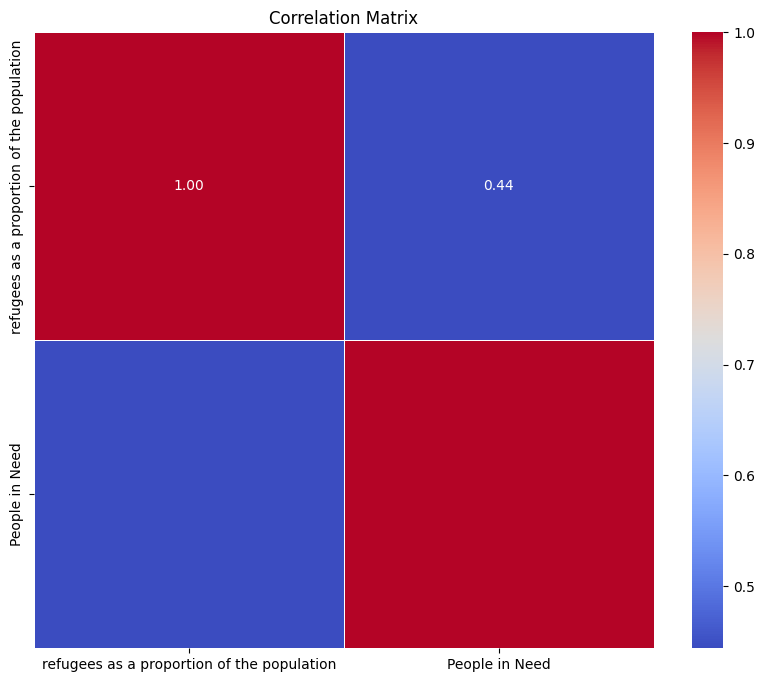

Pearson Correlation: 0.4438945453227282
Spearman Correlation: 0.5769307426828062


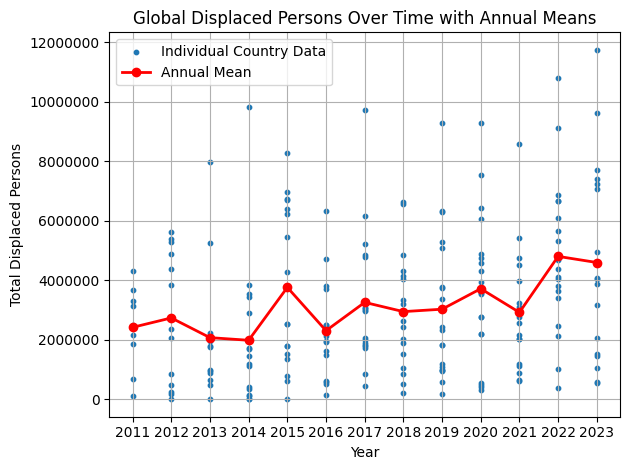

In [9]:
# correlation between UNOCHA and IDPs
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import skew, kurtosis

refugee_df = pd.read_csv('/Users/neilstein/Documents/Academic/Winter 25/Policy Lab/supplemented_ocha_v2.csv')
# merging refugee values
refugee_df['merged_refugees'] = refugee_df['IDPs of concern to UNHCR'] + refugee_df['Conflict Stock Displacement']

# scaling refugees to match PiN (refugees as a portion of total population)
refugee_df['scaled_refugees'] = refugee_df['merged_refugees'] / refugee_df['total_population']
refugee_df = refugee_df.rename(columns= {'scaled_refugees': 'refugees as a proportion of the population','PiN':'People in Need'})
corr_cols = ['refugees as a proportion of the population','People in Need']
correlation_matrix = refugee_df[corr_cols].corr()
correlation_values = correlation_matrix.values.flatten()

# Summary Statistics for refugee totals
pd.set_option('display.float_format', '{:.0f}'.format)
scaled_refugees_stats = refugee_df['refugees as a proportion of the population'].describe()
print("\nSummary Statistics for refugees as a proportion of the population:")
print(scaled_refugees_stats)
pd.reset_option('display.float_format')

# Summary Statistics for People in Need
pin_stats = refugee_df['People in Need'].describe()
print("\nSummary Statistics for PiN:")
print(pin_stats)

# Print the descriptive statistics
skewness = skew(correlation_values)
kurt = kurtosis(correlation_values)
mean_correlation = np.mean(correlation_values)
median_correlation = np.median(correlation_values)
std_correlation = np.std(correlation_values)
min_correlation = np.min(correlation_values)
max_correlation = np.max(correlation_values)

detailed_stats_dict = {
    'Mean': mean_correlation,
    'Median': median_correlation,
    'Standard Deviation': std_correlation,
    'Minimum': min_correlation,
    'Maximum': max_correlation,
    'Skewness': skewness,
    'Kurtosis': kurt
}
detailed_stats_df = pd.DataFrame([detailed_stats_dict])
print("\nDetailed Statistics:")
print(detailed_stats_df)


# Seaborn Heat Map:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')

plt.show()

# correlation exploration
correlation = refugee_df['refugees as a proportion of the population'].corr(refugee_df['People in Need'])
print(f"Pearson Correlation: {correlation}")
spearman_correlation = refugee_df['refugees as a proportion of the population'].corr(refugee_df['People in Need'], method='spearman')
print(f"Spearman Correlation: {spearman_correlation}")


# bonus chart to track global trends
from matplotlib.ticker import ScalarFormatter
yearly_means = refugee_df.groupby('Year')['merged_refugees'].mean().reset_index()

# building the scatter
plt.scatter(refugee_df['Year'], refugee_df['merged_refugees'], s=10, label='Individual Country Data')
plt.plot(yearly_means['Year'], yearly_means['merged_refugees'], color='red', linewidth=2, marker='o', label= 'Annual Mean') 

# adjusting units
ax = plt.gca() 
formatter = ScalarFormatter()
formatter.set_scientific(False)  
ax.yaxis.set_major_formatter(formatter)

# scatterplot design
plt.xlabel('Year')
plt.ylabel('Total Displaced Persons')
plt.title('Global Displaced Persons Over Time with Annual Means')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(min(refugee_df['Year']), max(refugee_df['Year'])+1, 1)) # Set x axis to every year
plt.tight_layout()
plt.show()